# Workshop on *Person verification in surveillance using feature extraction and learning*

Course: NICF- Vision Systems (SF)

Website: https://www.iss.nus.edu.sg/executive-education/course/detail/vision-systems/analytics-and-intelligent-systems

Contact: Tian Jing

Email: tianjing@nus.edu.sg


## Objective
In this workshop, we will perform the following four tasks
- Build a person verification model using feature extraction method 
- Build a machine learning model for person verification using siamese networks
- Apply the person verification model on a large dataset to find the most similar image given the query image
- Apply the person verification model on your own photo

## Installation guideline

- Open `Anaconda Prompt`

- Append the channel `conda-forge` into your conda configuration.

`conda config --append channels conda-forge`

- Create a new virtual environment `vscv` or install additional packages in your own environment
    
**[Windows, CPU version]**

`conda create -n vscv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow=1.10.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras=2.2.4 notebook=5.7.4`

**[Windows, GPU version, CUDA 9.0]**

`conda create -n vscv python=3.6 numpy=1.15.1 opencv=3.4.2 matplotlib=2.2.3 tensorflow-gpu=1.12.0 scipy=1.1.0 scikit-learn=0.19.1 spyder=3.3.2 yaml=0.1.7 keras-gpu=2.2.4 notebook=5.7.4`

**[Google Colab]**

Refer to another notebook file `wk_person_verification_colab_v4.0.ipynb`

- Activate the environment `vscv`

`conda activate vscv`

- Browse to the folder that contains the workshop files, then run Jupyter Notebook

`jupyter notebook`
    

## Submission guideline

Once you finish the workshop, rename your .ipynb file to be your name, and submit your .ipynb file into LumiNUS.

## Dataset

- We will use *Labeled Faces in the Wild* (LFW) dataset, specifically, `All images aligned with deep funneling`, http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz (111 MB). More information can be found at the original dataset website at http://vis-www.cs.umass.edu/lfw/

## Note
- For demonstration purposes, we will only use a subset of the dataset in this workshop. The whole dataset contains 5749 persons (folders).
- To reduce the time required in model training in this workshop, we will build a simple convolutional model.


In [1]:
# Load library
import keras
import os
import keras.backend as K
import cv2
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Dot, Conv2D, MaxPool2D, Flatten
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# # apply GPU in training if GPU is available in your computer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # model will be trained on GPU


Using TensorFlow backend.


# Exercise 1: Evaluate similarity of two person image using HoG feature extraction method

Objective
- Given two person images, extract their HoG features and calculate their cosine similarity (larger value indicates higher similarity)

The similarity of two images is 0.7289


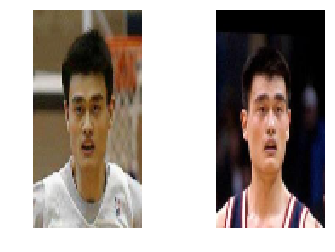

In [2]:
# Define the configuration of HoG feature extraction

# Resize the input image to a fixed resolution for feature extraction
IMG_HEIGHT = 128
IMG_WIDTH = 64

# Block size, Cell size, Stride size, Number of bins as defined in HoG.
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

# Step 1: Load images and resize images
test_image1 = cv2.imread('yao2.jpg')
test_image2 = cv2.imread('yao1.jpg')

test_image1 = cv2.resize(test_image1, (IMG_WIDTH, IMG_HEIGHT))
test_image2 = cv2.resize(test_image2, (IMG_WIDTH, IMG_HEIGHT))

# Step 2: Extract HoG features
hog = cv2.HOGDescriptor((IMG_WIDTH, IMG_HEIGHT), blockSize, blockStride, cellSize, nbins)
test_image1_hog = hog.compute(test_image1)
test_image2_hog = hog.compute(test_image2)

# Step 3: Normalize the HoG features and calculate their cosine similarity distance
test_image1_hog = test_image1_hog/np.linalg.norm(test_image1_hog)
test_image2_hog = test_image2_hog/np.linalg.norm(test_image2_hog)

sims = np.inner(np.transpose(test_image1_hog), np.transpose(test_image2_hog))
print('The similarity of two images is %.4f' % sims)

# Display the input images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.show()


# Explore LFW face dataset

The dataset consists of folders corresponding to each person. The folder name is the name of the person.

First, we map each class (identity) to an integer id, and build mappings as dictionaries.
- mappings from person name (folder name) and class id: `name_to_classid` and `classid_to_name`

Furthermore, in each folder, there is one or more images corresponding to the identity. We map each image path with an integer id, then build a few dictionaries
- mappings from imagepath and image id: `path_to_imageid` and `imageid_to_path`
- mappings from class id to image id: `classid_to_imageid` and `imageid_to_classid`

Summary 
- name: person name, folder name
- classid: integer number to indicate the person name
- path: path to save the person images
- imageid: integer number to indicate the image file index

In [45]:
# Define the path for the downloaded images
PATH = "lfw-deepfunneled/"



# We only use subset of this dataset, say 500 folders
USE_SUBSET = True

dirs = sorted(os.listdir(PATH))
print("Total number of classes (persons) in the full dataset: ", len(dirs))
if USE_SUBSET:
    dirs = dirs[1:501]
print("Total number of classes (persons) in workshop: ", len(dirs))

# Build two dictionaries
name_to_classid = {d: i for i, d in enumerate(dirs)}
classid_to_name = {v: k for k, v in name_to_classid.items()}

# read all directories
img_paths = {c: [PATH + subfolder + "/" + img
                 for img in sorted(os.listdir(PATH + subfolder))] 
             for subfolder, c in name_to_classid.items() if not subfolder.startswith(".")}

# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list

# map to integers
path_to_imageid = {v: k for k, v in enumerate(all_images_path)}
imageid_to_path = {v: k for k, v in path_to_imageid.items()}

# build mappings between images and class
classid_to_imageid = {k: [path_to_imageid[path] for path in v] for k, v in img_paths.items()}
imageid_to_classid = {v: c for c,imgs in classid_to_imageid.items() for v in imgs}


Total number of classes (persons) in the full dataset:  5750
Total number of classes (persons) in workshop:  500


# Prepare dataset to train a deep learning model for person verification

- Build paris of positive and negative training images
- Split dataset into train and test subsets for model training


In [46]:
# build pairs of positive image ids for a given classid
def build_pos_pairs_for_imageid(classid, max_num=50):
    imgs = classid_to_imageid[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j])
                 for i in range(len(imgs))
                 for j in range(i + 1, len(imgs))]
    print(pos_pairs)
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

# build pairs of negative image ids for a given classid
def build_neg_pairs_for_imageid(classid, classes, max_num=20):
    imgs = classid_to_imageid[classid]
    neg_classes_imageid = random.sample(classes, max_num+1)
    if classid in neg_classes_imageid:
        neg_classes_imageid.remove(classid)
    neg_pairs = []
    for id2 in range(max_num):
        img1 = imgs[random.randint(0,len(imgs)-1)]
        imgs2 = classid_to_imageid[neg_classes_imageid[id2]]
        img2 = imgs2[random.randint(0,len(imgs2)-1)]
        neg_pairs += [(img1, img2)]
    return neg_pairs

def open_all_images(id_to_path):
    all_imgs = []
    for path in id_to_path.values():
        temp = cv2.imread(path)
        temp = cv2.resize(temp, (100, 100))        
        all_imgs += [np.expand_dims(temp,0)]
    return np.vstack(all_imgs)

def build_train_test_data(num_classes, split=0.8):
    listX1 = []
    listX2 = []
    listY = []
    split = int(num_classes * split)
    
    # train
    for id in range(split):
        pos = build_pos_pairs_for_imageid(id)
        neg = build_neg_pairs_for_imageid(id, list(range(split)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    perm = np.random.permutation(len(listX1))
    X1_ids_train = np.array(listX1)[perm]
    X2_ids_train = np.array(listX2)[perm]
    Y_ids_train = np.array(listY)[perm]
    
    listX1 = []
    listX2 = []
    listY = []
    
    #test
    for id in range(split, num_classes):
        pos = build_pos_pairs_for_imageid(id)
        neg = build_neg_pairs_for_imageid(id, list(range(split, num_classes)))
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
            listY += [1]
        for pair in neg:
            if sum(listY) > len(listY) / 2:
                listX1 += [pair[0]]
                listX2 += [pair[1]]
                listY += [0]
    X1_ids_test = np.array(listX1)
    X2_ids_test = np.array(listX2)
    Y_ids_test = np.array(listY)
    return (X1_ids_train, X2_ids_train, Y_ids_train,
            X1_ids_test, X2_ids_test, Y_ids_test)

class Generator:

    def __init__(self, X1, X2, Y, batch_size, all_imgs):
        self.cur_train_index=0
        self.batch_size = batch_size
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = Y.shape[0]
        
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            imgs1 = self.X1[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs2 = self.X2[self.cur_train_index:self.cur_train_index+self.batch_size]

            yield ([self.imgs[imgs1], self.imgs[imgs2]],
                    self.Y[self.cur_train_index:self.cur_train_index+self.batch_size])


[(5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8)]
[(10, 11)]
[(17, 18)]
[(19, 20), (19, 21), (19, 22), (20, 21), (20, 22), (21, 22)]
[(26, 27), (26, 28), (26, 29), (27, 28), (27, 29), (28, 29)]
[(31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (31, 37), (31, 38), (31, 39), (31, 40), (31, 41), (31, 42), (31, 43), (31, 44), (31, 45), (31, 46), (31, 47), (31, 48), (31, 49), (32, 33), (32, 34), (32, 35), (32, 36), (32, 37), (32, 38), (32, 39), (32, 40), (32, 41), (32, 42), (32, 43), (32, 44), (32, 45), (32, 46), (32, 47), (32, 48), (32, 49), (33, 34), (33, 35), (33, 36), (33, 37), (33, 38), (33, 39), (33, 40), (33, 41), (33, 42), (33, 43), (33, 44), (33, 45), (33, 46), (33, 47), (33, 48), (33, 49), (34, 35), (34, 36), (34, 37), (34, 38), (34, 39), (34, 40), (34, 41), (34, 42), (34, 43), (34, 44), (34, 45), (34, 46), (34, 47), (34, 48), (34, 49), (35, 36), (35, 37), (35, 38), (35, 39), (35, 40), (35, 41), (35, 42), (35, 43), (35, 44), (35, 45), (35, 46), (35, 47), (35, 48), (35, 49), (36, 3

1155
Total images:  (1155, 100, 100, 3)


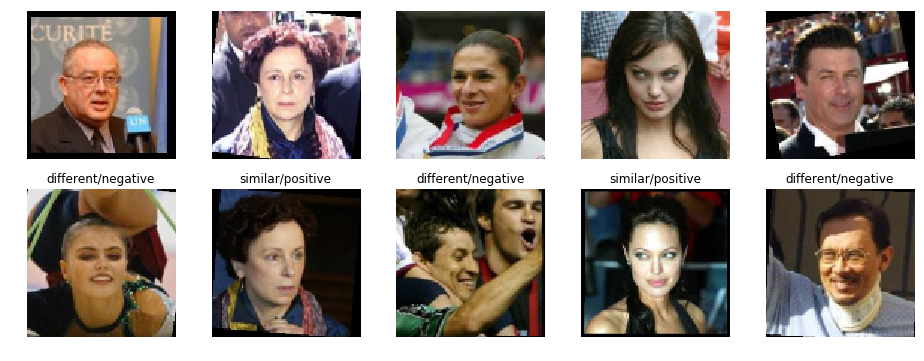

In [47]:
# Generate training imageid index and test imageid index
num_classes = len(name_to_classid) # Total number of persons used in this workshop
X1_ids_train, X2_ids_train, train_Y, X1_ids_test, X2_ids_test, test_Y = build_train_test_data(num_classes)

# Open all images
all_imgs = open_all_images(imageid_to_path)
print(len(all_imgs))
print('Total images: ', all_imgs.shape)

# Define an image dataloader
gen = Generator(X1_ids_train, X2_ids_train, train_Y, 32, all_imgs)
[x1, x2], y = next(gen.next_train())

# Display a few pairs of training images
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(x1[i], cv2.COLOR_BGR2RGB) / 255) # Convert image color format, as Opencv load image in RGR format
    plt.axis('off')
for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(x2[i], cv2.COLOR_BGR2RGB) / 255)
    if y[i]==1.0:
        plt.title("similar/positive")
    else:
        plt.title("different/negative")
    plt.axis('off')
plt.show()

# Prepare test image subset
test_X1 = all_imgs[X1_ids_test]
test_X2 = all_imgs[X2_ids_test]


# Exercise 2: Design and train a person verification model

Objectives
- Build a convolutional model. Warning: Large convolutions on high dimensional images can be very slow on CPUs.

In [48]:
# Define the loss function
def contrastive_loss(y_true, y_pred, margin=0.25):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    return K.mean( y_true * K.square(1 - y_pred) +
                  (1 - y_true) * K.square(K.maximum(y_pred - margin, 0)))

def accuracy_sim(y_true, y_pred, threshold=0.5):
    '''Compute classification accuracy with a fixed threshold on similarity.
    '''
    y_thresholded = K.cast(y_pred > threshold, y_true.dtype)
    return K.mean(K.equal(y_true, y_thresholded))


In [ ]:
#Define a model
inp = Input((100, 100, 3), dtype='float32')
x = Conv2D(16, 3, activation="relu", padding="same")(inp)
x = Conv2D(16, 3, activation="relu", padding="same")(x)
x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(50)(x)
shared_conv = Model(inputs=inp, outputs=x)

print('Input: ', all_imgs.shape)
print('Output: ', shared_conv.predict(all_imgs).shape)

shared_conv.summary()


In [50]:
# Define the siamese model
i1 = Input((100, 100, 3), dtype='float32')
i2 = Input((100, 100, 3), dtype='float32')

x1 = shared_conv(i1)
x2 = shared_conv(i2)

out = Dot(axes=-1, normalize=True)([x1, x2])

model = Model(inputs=[i1, i2], outputs=out)
model.compile(loss=contrastive_loss, optimizer='rmsprop', metrics=[accuracy_sim])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 50)           2002818     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot)                     (None, 1)            0           model_2[1][0]                    
          

In [ ]:
# Train the model, set smaller epoch if you don't have GPU

NUM_EPOCH = 5
model.fit_generator(generator=gen.next_train(), steps_per_epoch=train_Y.shape[0] // 32, epochs=NUM_EPOCH, validation_data=([test_X1, test_X2], test_Y), verbose=2)


Epoch 1/5
 - 478s - loss: 0.1752 - accuracy_sim: 0.5522 - val_loss: 0.1527 - val_accuracy_sim: 0.5638
Epoch 2/5


In [ ]:

# Step 1: Load images and resize images
test_image1 = cv2.imread('yao1.jpg')
test_image2 = cv2.imread('yao2.jpg')
#test_image2 = cv2.imread('bill1.jpg')

# Load image, convert image color format, change the shape of the image
test_image1 = cv2.resize(test_image1, (100, 100))
test_image2 = cv2.resize(test_image2, (100, 100))

# Step 2: Extract features using the pre-trained siamese model
# Note: need to expand the input image to be 4D to fit into the model
test_image1_coeff = shared_conv.predict(np.expand_dims(test_image1, 0))
test_image2_coeff = shared_conv.predict(np.expand_dims(test_image2, 0))

# Step 3: Normalize features and calculate their cosine similarity distance
# Normalize by L2-norm https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html

sims = np.inner(test_image1_coeff/np.linalg.norm(test_image1_coeff), test_image2_coeff/np.linalg.norm(test_image2_coeff))
print('The similarity of two images is %.4f' % sims)

# Plot the two given images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(test_image1, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(test_image2, cv2.COLOR_BGR2RGB) / 255)
plt.axis('off')
plt.show()


# Exercise 3: Apply the person verification model to find the most similar image given the query image


$\color{red}{\text{Q1. Complete the code to build an image similarity evaluation model.}}$

Tasks

- Randomly select a query image, apply the person verification model to find similar images from the data `all_imgs`
- Evaluate the similairty using the pre-trained siamese model
- Display the query image, top three similar images, and their respective confidence score.

In [11]:
# provide your anwer to Q1 here

# Load images and resize images

# Extract features using the pre-trained siamese model

# Normalize features and calculate their cosine similarity distance

# Find out the most similar image



$\color{red}{\text{Q2. Propose how to further boost the accuracy performance of the person verification model used in this workshop.}}$

For example: Apply the face detection on the input image, then use detected face as training data, instead of using the whole image as training data.

In [13]:
# Provide your answers here
#
#
#
#
#
#

**Once you finish the workshop, rename your .ipynb file to your name, and submit your .ipynb file into LumiNUS.**

Have a nice day!